# Урок 6

## Задание 2. Стохастический градиентный бустинг.

Возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию случайной выборки данных указанного объема

In [8]:
def select_random_data(X_data, y_data):
    # Создаем список индексов элементов, которые будем удалять
    tmp_idx = []
    
    # Формируем список индексов для удаления
    for i in range(int(X_data.shape[0]/2)):
        tmp_idx.append(np.random.randint(X_data.shape[0]))
    
    # print(tmp_idx)

    X_data = np.delete(X_data, tmp_idx, axis = 0)
    y_data = np.delete(y_data, tmp_idx)
    
    return X_data, y_data

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Реализуем функцию обучения стохастического градиентного бустинга.

In [10]:
def gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        X_train_half, y_train_half = select_random_data(X_train, y_train)
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_half, y_train_half)
            
            train_errors.append(mean_squared_error(y_train_half, gb_predict(X_train_half, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_half, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_half, bias(y_train_half, target))
            
            train_errors.append(mean_squared_error(y_train_half, gb_predict(X_train_half, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [11]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [12]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [13]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1102.646990095844
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5181.505391472057


In [14]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1847.2435227268
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 7168.844359708598


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [15]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [16]:
def get_error_plot(n_trees, train_err, test_err, train_err_stoch, test_err_stoch):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.plot(list(range(n_trees)), train_err_stoch, label='train error stochastic')
    plt.plot(list(range(n_trees)), test_err_stoch, label='test error stochastic')
    plt.legend(loc='upper right')
    plt.show()

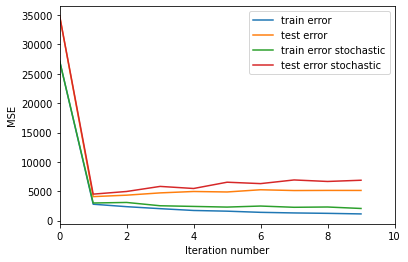

In [17]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [18]:
%%time
n_trees = 50
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 1min 5s


In [19]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 54.550996787815336
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5700.500416091413


In [20]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 360.9289341844608
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тестовой выборке: 10411.85257044662


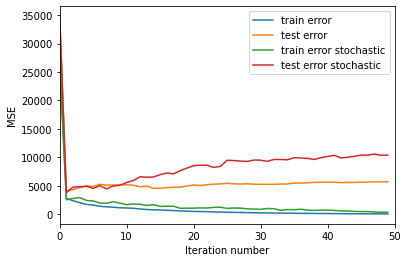

In [21]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

Теперь попробуем уменьшить шаг.

In [22]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [23]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1357.4260103747326
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3634.261633094058


In [24]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1315.3003392697194
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3784.828196141388


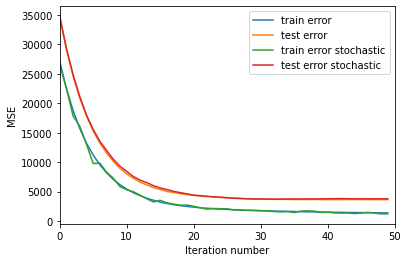

In [25]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [26]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [27]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 11630.74040323186
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 15812.93458587226


In [28]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 11599.000861087185
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 15719.816712249272


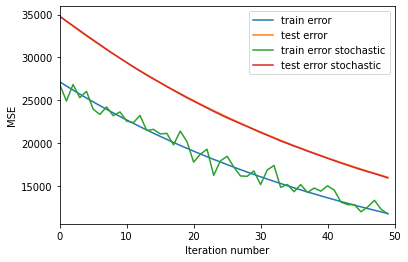

In [29]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем поиграть с глубиной деревьев

In [30]:
eta = 0.1
max_depth = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [31]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 2614.223831744751
Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 3490.860251639918


In [32]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 2562.923624641483
Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 3525.0795904067268


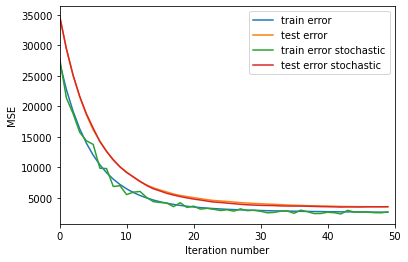

In [33]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

In [34]:
eta = 0.1
max_depth = 2

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [35]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2014.4777689602731
Ошибка алгоритма из 50 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 3479.4302831069476


In [36]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 1943.5353222194744
Ошибка алгоритма из 50 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 3522.2295412292747


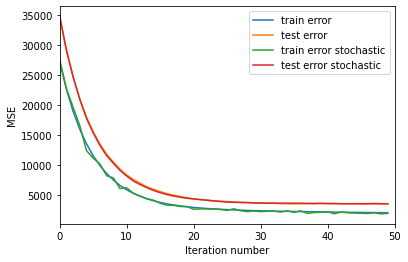

In [37]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

In [38]:
eta = 0.1
max_depth = 3

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [39]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1357.4260103747326
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3634.261633094058


In [40]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1309.2010679759803
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3506.0447261418085


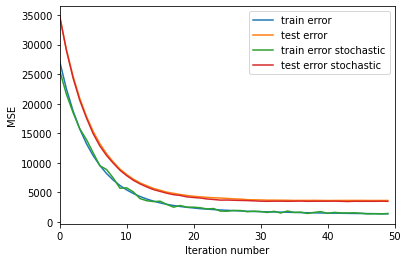

In [41]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

In [42]:
eta = 0.1
max_depth = 4

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [43]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 684.3725630441976
Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 3830.4719678239608


In [44]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 709.474165377204
Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 3595.5283704602048


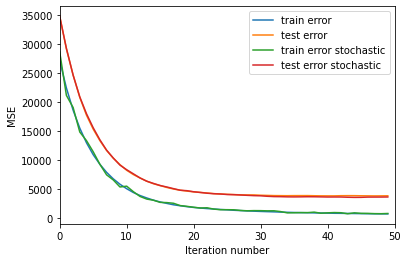

In [45]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

In [46]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [47]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 263.6658467962463
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 4059.9380913875575


In [48]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 350.8509808407248
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3472.9464923890305


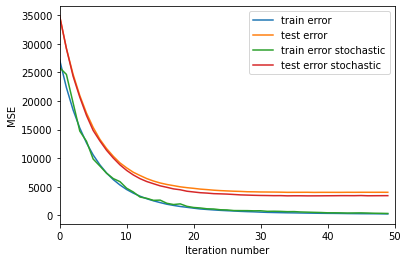

In [49]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

In [50]:
eta = 0.1
max_depth = 6

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees_stoch, train_errors_stoch, test_errors_stoch = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [51]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.1 на тренировочной выборке: 91.36482932873615
Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.1 на тестовой выборке: 4218.478267537987


In [52]:
evaluate_alg(X_train, X_test, y_train, y_test, trees_stoch, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.1 на тренировочной выборке: 185.47142572240355
Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.1 на тестовой выборке: 3978.06380698814


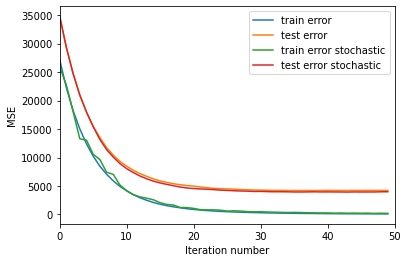

In [53]:
get_error_plot(n_trees, train_errors, test_errors, train_errors_stoch, test_errors_stoch)

Мы видим, что при применении стохастического градиентного бустинга приводит даже к лучшим результатам на тестовой выборке, чем применение обычного градиентного бустинга. Учитывая то, что при обучении модели с использованием стохастического градиентного бустинка используется в 2 раза меньше ресурсов, то результат впечатляет.